# Final assignment: Part 1

Part 1: The only type of model you should use for this part, is the H2OGeneralizedLinearEstimator model. You should:

1. Deal appropriately with missings (for all numeric variables, -99 means missing).
2. Deal with numerics - i.e. for at least some try linear splines (or another method of your choice to deal with non-linear effects)
3. Deal with hccvs (eg using the feature encoding library that we looked at in lecture) (You do not need to deal with low cardinality categorical features since H2O will one-hot them for you.)
4. Try out some interactions
5. Try out some other features (eg division of numerics).

Presumably you will train various models, submit your predictions on Kaggle and note the public leaderboard score.

- Choose your best model, and for it: Create a function which carries out any data preparation and fitting:
• The name of your function must be fn logistic
• You must save your function in a (plain text) file with exactly the following
name
      en_<studentnumber>.py
For example, if your student number is 123456789 then your function must be stored as en 123456789.py
• The only input for your function should be the df train and df test datasets created in 01a ReadData. You may choose the smaller or larger train data, as you wish, but the score in your return statement should be consistent. Any data manipulation should be done by code in your function.
• The only output from your function should be three items - in this order: – Your trained H2OGeneralizedLinearEstimator object
– The test data, the data that you feed your object when you make predictions.
– Your Kaggle public leaderboard score for this model, hardcoded as a number to 3 d.p.
• Your function should be totally self contained. If it requires any import eg of numpy or pandas or from sklearn, you should do those imports in your function.
3
    
• There should be no code at all in your .py file before the def statement and no code after the end of the return statement.
• The code in your function should tidy (especially if you download if from a ipynb) and it should be well commented.


**Import packages**

In [270]:
### Import packages
import os
import numpy as np
import pandas as pd
import pickle
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

#category encoders
from category_encoders import LeaveOneOutEncoder

#needed for fn_computeRatiosOfNumerics()
from itertools import permutations

In [271]:
#### Set directories
print(os.getcwd())
dirRawData = "../input/"
dirPData   = "../PData/"
dirPOutput = "../POutput/"

/home/jovyan/Projects/final_assignment/PCode


In [272]:
dirPData

'../PData/'

In [273]:
### Functions
def fn_MAE(actuals, predictions):
    return np.round(np.mean(np.abs(predictions - actuals)))

def fn_RMSE(actuals, predictions):
    return np.round(np.sqrt(np.mean((predictions - actuals)**2)))

def fn_tosplines(x):
    x = x.values
    # hack: remove zeros to avoid issues where lots of values are zero
    x_nonzero = x[x != 0]
    ptiles = np.percentile(x_nonzero, [10, 20, 40, 60, 80, 90])
    ptiles = np.unique(ptiles)
    print(var, ptiles)
    df_ptiles = pd.DataFrame({var: x})
    for idx, ptile in enumerate(ptiles):
        df_ptiles[var + '_' + str(idx)] = np.maximum(0, x - ptiles[idx])
    return(df_ptiles)

def fn_computeRatiosOfNumerics(df, variables):
## Process:
# 1. Gets passed most important numeric variables
# 2. Computes all pairwise ratios between each of these i.e
# - get all permutations of length 2, and divide term 1 by term 2
# e. Returns a dataframe containing engineered variables, with appropriately named columns

#     variables = ['A','B','C'] #debugging
    pairs = []
    lst_series = []
    for i in range(len(variables)+1):
        for subset in permutations(variables, i):
            if len(subset)==2: pairs.extend([subset])
    temp_colnames = []
    for elem in pairs:
        ## create column names
        temp_colname = 'ratio_{}.{}'.format(elem[0],elem[1])
        temp_colnames.append(temp_colname)
        #compute ratio
        try: 
            srs_pair_ratio = df[elem[0]]/df[elem[1]]
        except ZeroDivisionError:  
            #if denominator is 0, will catch error and assign nan value to that ratio
            srs_pair_ratio = np.nan
            srs_pair_ratio = np.nan
        srs_pair_ratio.rename(temp_colname, inplace=True)
        lst_series.append(srs_pair_ratio)
    #create dataframe with appropriate column names
    df_2 = pd.DataFrame(index = df.index, columns = temp_colnames)
    #fill dataframe with series
    for idx, col in enumerate(df_2):
        df_2[col] = lst_series[idx]
    
    
    # Seems df division already catches ZeroDivisonError and assigns infinity value when denom = 0 but not numerator 
    # In such case, want 0 coefficient.
    # Also want 0 coefficients when both numerator and denom are 0
    # therefore replace all inf and nan values with zeroes
    df_2.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return df_2

In [274]:
#### Load data via pickle
f_name = dirPData + '01_df_250k.pickle'

with (open(f_name, "rb")) as f:
    dict_ = pickle.load(f)

df_train = dict_['df_train']
df_test  = dict_['df_test']

del f_name, dict_

In [275]:
f_name = dirPData + '01_vars.pickle'

with open(f_name, "rb") as f:
    dict_ = pickle.load(f)

vars_ind_numeric     = dict_['vars_ind_numeric']
vars_ind_hccv        = dict_['vars_ind_hccv']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_notToUse        = dict_['vars_notToUse']
var_dep              = dict_['var_dep']

del f_name, dict_

In [276]:
#add 'unique_id' to vars_notToUse, remove it from list of numeric variables
if 'unique_id' not in vars_notToUse:
    vars_notToUse.extend(['unique_id']) ### weirdly, 'id' doesn't appear in index. I believe should use 'unique_id' instead but will leave both in for now.
vars_ind_numeric = [var for var in vars_ind_numeric if var not in vars_notToUse]
# vars_ind_numeric
vars_notToUse


['id', 'unique_id']

In [277]:
### Set index for train, val, design, test data
#### Create folds to seperate train data into train, val, design, test
rng = np.random.RandomState(2020)
fold = rng.randint(0, 10, df_train.shape[0])
df_train['fold'] = fold

#get indices for each subset
# idx_train  = df_train['fold'].isin(range(6))
# idx_val    = df_train['fold'].isin([6, 7])
# idx_design = df_train['fold'].isin(range(8))
# idx_test = df_train['fold'].isin([8,9])
idx_train  = df_train['fold'].isin(range(8))
idx_val    = df_train['fold'].isin([7, 8])
idx_design = df_train['fold'].isin(range(9))

#drop fold column
df_train.drop(columns='fold', inplace=True)

In [278]:
df_train.shape
df_test.shape
# df_train['fold']

(296690, 96)

**Deal with missings**

In [279]:
#### IDENTIFY NULLS, MISSINGS
print(df_train.shape)
#collapse axis = 0 i.e. sum missing values,
#store as series
## Check for nulls
srs_null = df_train.isnull().sum(axis=0) 
print(srs_null[srs_null>0]) #show which features have null values

## Check for missings numerics which have been replaced with -99 (placeholder, really it is missing)
#get percentage of missing values for each feature
srs_missing = pd.DataFrame(df_train.loc[:,:]==-99).sum(axis=0)/len(df_train)
# print(srs_missing[srs_missing!=0])

#get list of variables which have more than x% missing values
#arbitrarily setting threshold to 50% but could tune this parameter if time permits
many_missings = [var for var in df_train.columns.values if srs_missing[var]>=.5 ]  

## DO NOT USE VARIABLES WITH MORE THAN x% MISSINGS
#add vars from many_missings to vars_notToUse, remove them from list of numeric variables
vars_notToUse.extend(many_missings)
#turn into set and set back into list - deals with issue of duplicates when running code multiple time
vars_notToUse = list(set(vars_notToUse)) 

#remove variables in many_missings from var_ind_numeric
vars_ind_numeric = [var for var in vars_ind_numeric if var not in vars_notToUse]
# print([var for var in vars_ind_numeric if var in vars_notToUse])  #double check they've been removed: printed list should be empty

(250000, 97)
Series([], dtype: int64)


In [280]:
### MEAN-IMPUTE MISSINGS
# list of variables to impute
vars_toImpute = [var for var in srs_missing[srs_missing>0].index.tolist() if var not in many_missings]

#get subset dataframe (only cols which are in variables_toImpute)
#get only values != -99 -> this will mean that the missings will be returned as NaN. Can then use fillna
df_temp=df_train[vars_toImpute][df_train[vars_toImpute]!=-99].copy()  #make a working copy

#use fillna: computing the mean of each column and filling NaNs with this mean value.
df_temp.fillna(df_temp.mean(), inplace=True)

df_train[vars_toImpute] = df_temp

In [281]:
df_train.shape

(250000, 97)

**Prepare basis functions**

In [282]:
### Spline numeric variables with cardinality higher than 8
# define variables to spline
vars_ind_tospline = df_train[vars_ind_numeric].columns[(df_train[vars_ind_numeric].nunique() > 8)].tolist()
#Find the percentiles on train data only, then apply same percentiles to both train and test data, even if test data distribution is very different.
#update df_train, df_test
for var in vars_ind_tospline:
    df_ptiles = fn_tosplines(df_train[var])
    df_train.drop(columns=[var], inplace=True)
    df_test.drop(columns=[var], inplace=True)
    vars_ind_numeric.remove(var)
    df_train = pd.concat([df_train, df_ptiles], axis=1, sort=False)
    df_test = pd.concat([df_test, df_ptiles], axis=1, sort=False)
    vars_ind_numeric.extend(df_ptiles.columns.tolist())


a04 [ 18.          36.          81.08778636  84.         180.        ]
a15 [1. 2. 3. 4. 5. 6.]
b01 [ 9. 26. 46. 54. 77. 87.]
b05 [ 9. 10. 13. 14. 17. 19.]
c01 [11. 21. 54. 88.]
c03 [1. 2. 4. 5.]
d01 [1.       3.       4.810065 5.       9.      ]
d02 [1.         1.35343073 2.        ]
d03 [1.         1.80588394 2.        ]
e02 [11. 20. 41. 60. 80. 90.]
e04 [12. 18. 39. 60. 81. 89.]
e05 [ 9. 19. 39. 59. 79. 89.]
e06 [20. 61. 76. 89.]
e08 [16. 40. 61. 81. 90.]
e09 [18. 43. 62. 79. 90.]
e12 [11. 20. 41. 59. 79. 89.]
e15 [13. 22. 36. 59. 83. 90.]
f01 [13. 41. 59. 75.]
f02 [10. 19. 40. 58. 79. 90.]
f06 [ 9. 19. 60.]
f11 [ 4.  6.  9. 11. 13. 15.]
f13 [ 4.  6.  8.  9. 10. 11.]


In [283]:
df_train.shape

(250000, 208)

In [284]:
df_test.shape


(296690, 207)

In [285]:

# for convenience store dependent variable as y
y = df_train[var_dep].values.ravel()

In [286]:
# df_train.shape
# df_test.shape

**HCCV**

In [287]:
### If want to use some cardinality threshold other than 30, can edit threshold below:
th_card = 30
srs_card = df_train[vars_ind_categorical].nunique()
# srs_card = df_train_1m[cols_notNumeric].nunique()
print(srs_card.min())
print(srs_card.max())
print(srs_card[srs_card>th_card])
vars_ind_hccv = srs_card[srs_card>th_card].index.values.tolist()  #stores names of categorical variables with cardinality higher than threshold


1
21244
e17       82
e18      684
e19    21244
f10     1704
dtype: int64


- HCCV encoding using category_encoders

In [288]:
enc = LeaveOneOutEncoder(cols=vars_ind_hccv, sigma=0.3)
enc.fit(df_train[idx_design], y[idx_design])
df_train = enc.transform(df_train)  #encode hccvs in train data
# df_train[vars_ind_hccv].head()

df_test['target'] = np.nan  #add NaN target column to test dataset in order for it to have same shape as df_train
df_test = enc.transform(df_test)  #encode hccvs in test data
df_test.drop(columns='target', inplace=True)  #drop target column from df_test 

In [289]:
# df_train[vars_ind_hccv]  #see newly added hccv columns in train data

In [290]:
### Define features to be used
features = vars_ind_numeric+vars_ind_categorical

**Try out some interactions**

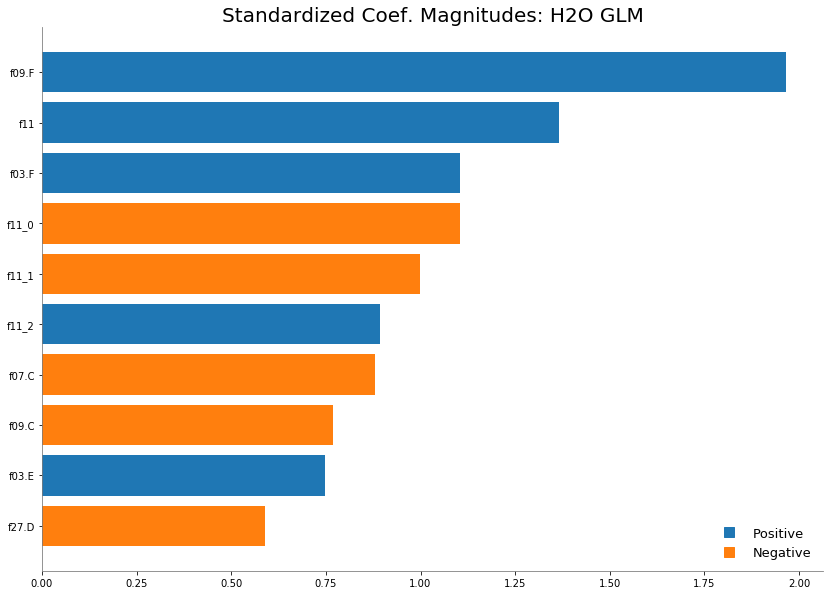

In [29]:
########## TODO #############

### Inspect coefficients from basic model with no interactions
#load basic model
# glm_basic_path=dirPData + 'GLM_model_python_1594684701152_8'
glm_basic_path='/home/jovyan/Projects/final_assignment/PCode/../PData/GLM_model_python_1594684701152_8'
glm_basic = h2o.load_model(path = glm_basic_path)  # load the model
#plot
glm_basic.std_coef_plot(num_of_features=10)
#get list of 5 most important variables
# vars_mostImp = [var[0].split('.')[0] for var in glm_basic.varimp()[0:5]]
#note that glm_basic.varim() is made up of some onehots created by H2o on the fly when building the model, and thus some aren't actually present in the train/test frames
#therefore can't refer to them before running a model, and we need to refer to the original variables before h2o onehots them
# we extract these by:
# - getting only the name of the variable
# - splitting on onehot delimiter '.' and keeping only first part of result. This is name of original variable
vars_mostImp = [var[0].split('.')[0] for var in glm_basic.varimp()[0:5]]
#vars_mostImp = [var.split('.')[0] for var in vars_mostImp]

In [ ]:
## Maually add interaction columns to both TRAIN and TEST datasets (need exact same columns across both datasets)
# df_enum.interaction(['A', 'B'], pairwise=False, max_factors=100, min_occurrence=1)

- df_all.any_factor
- is.factor() and as.factor()
- df_all[colname].levels()
- df_all.interaction(['col1','col2'], args)

**Try out some other features e.g. division of numerics**

In [292]:
############## TODO #############
#define THREE most important numeric variables
glm_basic = h2o.load_model(path = glm_basic_path)  # load the basic model
# plot largest standardised coefficients
# glm_basic.std_coef_plot(num_of_features=10)
# Get list of THREE most important variables
vars_mostImp_numeric=[]
for var in glm_basic.varimp():
    orig_var = var[0].split('.')[0]
    if orig_var in vars_ind_numeric:  #check if numeric
        #add to list of important numeric vars
        vars_mostImp_numeric.append(orig_var)
    if len(vars_mostImp_numeric)>= 3:
        break

### COMPUTE RATIO COLUMNS FOR BOTH DATASETS
df_temp_train = fn_computeRatiosOfNumerics(df_train, vars_mostImp_numeric)
df_temp_test = fn_computeRatiosOfNumerics(df_test, vars_mostImp_numeric)

#append new columns to df_train and df_test
df_train[df_temp_train.columns.values] = df_temp_train
df_test[df_temp_test.columns.values] = df_temp_test

#
vars_ind_numeric.extend(df_temp_train.columns.tolist())

In [265]:
# df_train[vars_mostImp_numeric]
# df_train

In [293]:
# ### COMPUTE RATIO COLUMNS FOR BOTH DATASETS
# df_temp_train = fn_computeRatiosOfNumerics(df_train, vars_mostImp_numeric)
# df_temp_test = fn_computeRatiosOfNumerics(df_train, vars_mostImp_numeric)

# #append new columns to df_train and df_test
# df_train[df_temp_train.columns.values] = df_temp_train
# df_test[df_temp_test.columns.values] = df_temp_test

# # df_train

In [294]:
# # temp2[0][0]
# temp_colnames = []
# #compute ratios between columns
# for elem in temp2:
#     temp_colname = 'ratio_{0}_{1}'.format(elem[0],elem[1])
#     temp_colnames.append(temp_colname)

# # elem = temp2[0]
# # temp_colname = 'ratio_{0}_{1}'.format(elem[0],elem[1])
# # temp_colnames.append(temp_colname)

In [295]:
# temp_colnames

**Start the h2o JVM and load our data if it not already there**

In [296]:
# h2o.init(port=54321)
h2o.connect(port=54321)

Connecting to H2O server at http://localhost:54321 ... successful.


H2O cluster uptime:,5 hours 13 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,"1 year, 2 months and 7 days !!!"
H2O cluster name:,H2O_from_python_jovyan_tyjfu2
H2O cluster total nodes:,1
H2O cluster free memory:,1.913 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


<H2OConnection to http://localhost:54321, no session>

In [297]:
# # remove all data loaded in JVM
# for key in h2o.ls()['key']:
#     h2o.remove(key)

In [298]:
# Is df_train already in the JVM?
h2o.ls()

,key
0,GLM_model_python_1594684701152_8
1,GLM_model_python_1594734597080_110
2,GLM_model_python_1594734597080_144
3,GLM_model_python_1594734597080_177
4,GLM_model_python_1594734597080_77
5,Key_Frame__upload_80bfcdb5206c94eb229c20208713...
6,Key_Frame__upload_811edd1e25f74452b20e67239c29...
7,Key_Frame__upload_822265a3340d75ec177293124680...
8,Key_Frame__upload_920404040d2ca40a890976dc6af0...
9,Key_Frame__upload_98b5b08c8136e3ecf9d4cbd87bb7...


In [30]:
# It if is, then just create a handle:
# h2o_df_train = h2o.get_frame('df_train')
# h2o_df_test = h2o.get_frame('df_test')


In [299]:
# Otherwise run this code.
h2o_df_train = h2o.H2OFrame(df_train[vars_ind_numeric + vars_ind_categorical + var_dep],
                           destination_frame='df_train')
h2o_df_test = h2o.H2OFrame(df_test[vars_ind_numeric + vars_ind_categorical],
                           destination_frame='df_test')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
# h2o_df_test = h2o.H2OFrame(df_test[vars_ind_numeric + vars_ind_categorical],
#                            destination_frame='df_test')

Change target to enum type as we are building a classification model

In [300]:
h2o_df_train[var_dep].types

{'target': 'int'}

In [301]:
#### Set target type to enum
h2o_df_train[var_dep] = h2o_df_train[var_dep].asfactor()
h2o_df_train[var_dep].types

{'target': 'enum'}

In [302]:
# var_dep

**Define the features to be used**

In this quick notebook, we ignore the hccv's.  For the main assigment you should deal sensibly with them.

In [303]:
# Need some proper way to deal with hcccv (eg target encoding).  For now just remove.
features = vars_ind_numeric + vars_ind_categorical
# features = [var for var in features if var not in vars_ind_hccv]


In [304]:
# print([col for col in h2o_df_train2.columns if col not in features])

**GridSearch**


I have more or less randomly chosen the list below to search for min leaf size.

In [305]:
# [2**idx for idx in 7+np.arange(10)]

In [306]:
# hyper_params = {'min_rows' : [2**idx for idx in 7+np.arange(10)]} 
# search_criteria = {'strategy': "Cartesian"}

In [307]:
# grid_dt = H2OGridSearch(
#                     H2OGradientBoostingEstimator(
#                         seed = 2020,   
#                         nfolds = 5,
#                         ntrees = 1,
#                         max_depth = 20,
#                         #min_rows = 1,
#                         sample_rate = 1,
#                         col_sample_rate = 1,
#                         ),
#                     grid_id = 'grid_dt',
#                     search_criteria = search_criteria,
#                     hyper_params = hyper_params)

In [308]:
# vars_mostImp

['f09.F', 'f11', 'f03.F', 'f11_0', 'f11_1']

**lambda_search for alpha and lambda given an identity link**

In [309]:
idx_h2o_train  = h2o.H2OFrame(idx_train.astype('int').values)
idx_h2o_val    = h2o.H2OFrame(idx_val.astype('int').values)
idx_h2o_design = h2o.H2OFrame(idx_design.astype('int').values)
# idx_h2o_test   = h2o.H2OFrame(idx_test.astype('int').values)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [310]:
%%time
##### WORKING AS OF 03h50 14.07.20
## To run GLM on categorical data, set the family to "multinomial" (or "binomial" when there are only two classes). 
# had to do the above as h2o wouldn't run model saying it wasn't getting a numeric 
# model=H2OGeneralizedLinearEstimator(  alpha=0.99
# #                                         , family='gaussian'
#                                         , family='binomial'
# #                                         , link='identity'
#                                         , link='logit'
#                                         , lambda_search=True
#                                         , lambda_min_ratio=1e-7
#                                         , nlambdas=200
#                                         , early_stopping=False
#                                         , nfolds=10
#                                         , seed=2020
#                                         )
# model.train(x=features, 
#             y='target',
#             training_frame=h2o_df_train[idx_h2o_design, :])


## To run GLM on categorical data, set the family to "multinomial" (or "binomial" when there are only two classes). 
# had to do the above as h2o wouldn't run model saying it wasn't getting a numeric 

# missing_values_handling -> MeanImputation: deals with new sample having categorical levels not seen in training. Replaces the unseen value with the most frequent level present in training.
# Interactions-> Specifies the predictors to 
# keep_cross_valudation_* -> set to false as only concerned with best final model. Saves some memory in H2o cluster.
model=H2OGeneralizedLinearEstimator(  alpha=0.99
#                                         , family='gaussian'
                                        , family='binomial'
#                                         , link='identity'
                                        , link='logit'
                                        , lambda_search=True
                                        , lambda_min_ratio=1e-7
                                        , nlambdas=100
                                        , early_stopping=True
                                        , nfolds=10
                                        , seed=2020
                                        , keep_cross_validation_models=False
                                        , keep_cross_validation_predictions=False
                                        , keep_cross_validation_fold_assignment=False
#                                         , interactions=vars_mostImp[0:2]
                                        , missing_values_handling='mean_imputation'
                                   )
# model.train(x=features, 
#             y='target',
#             training_frame=h2o_df_train[idx_h2o_train, :],
#             validation_frame=h2o_df_train[idx_h2o_val, :])
model.train(x=features, 
            y='target',
            training_frame=h2o_df_train[idx_h2o_design, :])

glm Model Build progress: |██████████████████████████████████████████████| 100%
CPU times: user 6 s, sys: 344 ms, total: 6.34 s
Wall time: 26min 12s


In [ ]:
# GLM basic, no interactions, no mean imputation for missing level values in test
# model name: GLM_model_python_1594684701152_8

# GLM basic, no interactions, WITH mean imputation for missing level values in test
# model name: GLM_model_python_1594734597080_177

# GLM numerical divisons, no interactions, WITH mean imputation for missing level values in test
# model name: GLM_model_python_1594734597080_426



In [311]:
glm_curr = model
# save the model
glm_curr_path = h2o.save_model(model=glm_curr, path=dirPData, force=True)
glm_num_meanImpute_path = glm_curr_path

In [312]:
# glm_num_meanImpute_path

'/home/jovyan/Projects/AmesHousing/PData/GLM_model_python_1594734597080_426'

In [ ]:
# save the model
# glm_bst_path = h2o.save_model(model=glm_curr, path=dirPData, force=True)
# glm_bst_path
# glm_bst_path=dirPData + 'GLM_model_python_1594684701152_8'
glm_bst_path='/home/jovyan/Projects/final_assignment/PCode/../PData/GLM_model_python_1594684701152_8'
glm_bst = h2o.load_model(path = glm_bst_path)  # load the model

In [313]:
temp_preds = model.predict(h2o_df_test)

glm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e20' has levels not trained on: [30146, BE271, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e13' has levels not trained on: [Q, S]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e24' has levels not trained on: [J, M, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'e03' has levels not trained on: [J, nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'c09' has levels not trained on: [nan]
  warnings.warn(w)
/opt/conda/lib/python3.6/site-packages/h2o/job.py:69: UserWarning: Test/Validation dataset column 'a18' has levels not trained on: [D]
  warnings.warn(w)


In [314]:
temp_preds
df_test['Predicted'] = np.round(temp_preds[2].as_data_frame(), 5)
df_preds = df_test[['unique_id', 'Predicted']].copy()
df_test[['unique_id', 'Predicted']].to_csv(dirPOutput + 'part1_preds_num_meanImpute_250k.csv', index=False)
# h2o_df_train[idx_h2o_val]

In [ ]:
### Inspect coefficients
#plot
glm_bst.std_coef_plot(num_of_features=10)
#get list of 5 most important variables
vars_mostImp = [var[0] for var in glm_bst.varimp()[0:5]]
#note that vars_mostImp is made up of onehots created by H2o and thus some aren't actually present in the train/test frames
#we need to refer to the original variables before h2o onehots them
vars_mostImp = [var.split('.')[0] for var in vars_mostImp] #split on the onehot delimiter and keep only the first part of the variable name (i.e. the original variable name)

In [ ]:
# df_train['f09.F']
# [var.split('.')[0] for var in vars_mostImp]

In [ ]:
bst_pred_train = glm_bst.predict(h2o_df_train[idx_h2o_train, :])
bst_pred_val   = glm_bst.predict(h2o_df_train[idx_h2o_val, :])
# bst_pred_test  = glm_bst.predict(h2o_df_all[idx_h2o_test, :])

bst_pred_train = bst_pred_train.as_data_frame().values.ravel()
bst_pred_val   = bst_pred_val.as_data_frame().values.ravel()
# bst_pred_test  = bst_pred_test.as_data_frame().values.ravel()

print('train error', fn_MAE(y[idx_train], bst_pred_train))
print('val error',   fn_MAE(y[idx_val], bst_pred_val))
# print('test error',  fn_MAE(y[idx_test], bst_pred_test))

h2o.show_progress()

# AC run gives
#train error 11950.0
#val error 12077.0
#test error 13667.0
# And these should be reproduced by this code

In [ ]:
bst_pred_train

In [ ]:
# len(set(df_test[vars_ind_numeric+vars_ind_categorical].columns.values))

In [ ]:
# len(df_test[~df_test[['unique_id','b06']]].columns)
# vars_notToUse
# temp = ['unique_id','b06']
# df_test[temp]
# set(features) == set(vars_ind_numeric+vars_ind_categorical) #only order differs
# len(features)

**Create Predictions**

When, the h2o tries to make predictions, we get a warning telling us that in some features there are some observations with new levels of the factors and these values were not present in the training dataset.  There is not alot we can do about this.  You should make sure you udnerstand how H2O makes predictions in such a case.

In [ ]:
# h2o_df_test = h2o.H2OFrame(df_test[vars_ind_numeric + vars_ind_categorical],
#                            destination_frame='df_test')

In [ ]:
preds = glm_bst.predict(h2o_df_test)

# preds = model.predict(h2o_df_test)
# There is no need to round your predictions


In [ ]:
preds

In [ ]:
df_test['Predicted'] = np.round(preds[2].as_data_frame(), 5)
df_preds = df_test[['unique_id', 'Predicted']].copy()
df_test[['unique_id', 'Predicted']].to_csv(dirPOutput + 'part1_preds_250k.csv', index=False)

In [ ]:
df_preds

Now you can submit 04b_df_preds_dt_250k.csv on Kaggle.  You should get an AUROC of around 0.75

**Note**

If you shut down your h2o JVM in this session, then any other Python notebooks open will also loose the JVM since they all connect to the same JVM!  

In [ ]:
h2o.cluster().shutdown()